# ***MUSIC RECOMMENDATION SYSTEM ML PROJECT***

# LOAD SPOTIFY DATASET

In [ ]:
import pandas as pd
df = pd.read_csv("/content/data.csv.zip")
df = df.sample(n=5000, random_state=42).reset_index(drop=True)
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.910,1977,0.500,['Idris Muhammad'],0.894,273067,0.5210,0,0KdzyvsBqX1HV3uLxGm2JV,0.772,4,0.068,-7.048,1,Camby Bolongo,34,1977,0.0847,126.805
1,0.583,1976,0.930,['Stan Getz'],0.585,182200,0.2720,0,1f4eO5waC6glPLXUhYKLm2,0.115,11,0.128,-16.693,0,Just One of Those Things,26,1976,0.0802,90.104
2,0.647,1994,0.157,"['Warren G', 'The Twinz']",0.878,179933,0.5200,1,1X07ZfF5KQt8dyJ5kAkVAQ,0.000,7,0.173,-12.609,1,Recognize,38,1994-06-07,0.4030,90.744
3,0.196,1957,0.937,['Red Garland Quintet'],0.463,925947,0.2870,0,5wmMDeM4qvLfwqLa2cvoks,0.837,0,0.112,-11.758,0,Soul Junction,13,1957,0.0363,186.764
4,0.422,1921,0.995,['Ignacio Corsini'],0.648,154240,0.0995,0,0SK1upzAP6NvIgF0uGh6z2,0.846,11,0.112,-22.429,1,Flor Marchita - Remasterizado,0,1921-03-20,0.1050,71.978


## FEATURES AND SCALING

In [ ]:
#select relevant numerical features for clustering
from sklearn.preprocessing import StandardScaler
numerical_features = ["valence","danceability","energy","tempo","acousticness","liveness","speechiness","instrumentalness"]
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)
df_scaled

,valence,danceability,energy,tempo,acousticness,liveness,speechiness,instrumentalness
0,1.473178,2.032267,0.142150,0.310507,-0.005840,-0.783298,-0.107375,1.916073
1,0.226049,0.276101,-0.771789,-0.886487,1.126217,-0.446557,-0.133457,-0.171477
2,0.470135,1.941333,0.138480,-0.865614,-0.908852,-0.194001,1.737477,-0.536877
3,-1.249911,-0.417272,-0.716732,2.266056,1.144646,-0.536354,-0.387900,2.122604
4,-0.387981,0.634154,-1.404939,-1.477663,1.297342,-0.536354,0.010283,2.151200
...,...,...,...,...,...,...,...,...
4995,0.336651,-0.019435,0.810170,0.374302,-0.837769,-0.598090,-0.353124,-0.536877
4996,1.507503,1.009258,1.357065,-0.824128,-1.106567,0.434583,-0.270821,-0.536877
4997,-0.681647,-1.826752,-0.599278,-2.003804,0.999848,0.114678,-0.387900,-0.536835
4998,-0.906665,-0.815109,-1.495966,-0.516212,1.284178,-0.592478,-0.412243,-0.287769


# TRAIN TEST SPLIT

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df_scaled,test_size=0.2,random_state=42)

# ELBOW METHOD PLOT

TO FIND OPTIMAL K



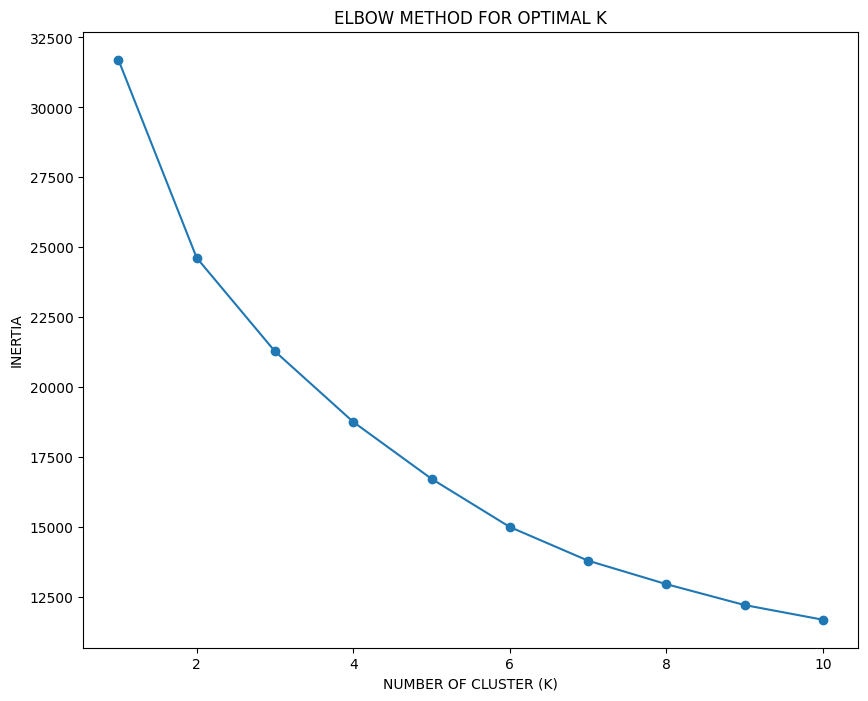

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_values  = range(1,11)
for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(train_data)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,8))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("NUMBER OF CLUSTER (K)")
plt.ylabel("INERTIA")
plt.title("ELBOW METHOD FOR OPTIMAL K")
plt.show()

# APPLYING KMEANS

In [ ]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_scaled)

In [ ]:
df['Cluster'].value_counts()

,count
Cluster,
2,1570
1,1279
4,1207
3,734
0,210


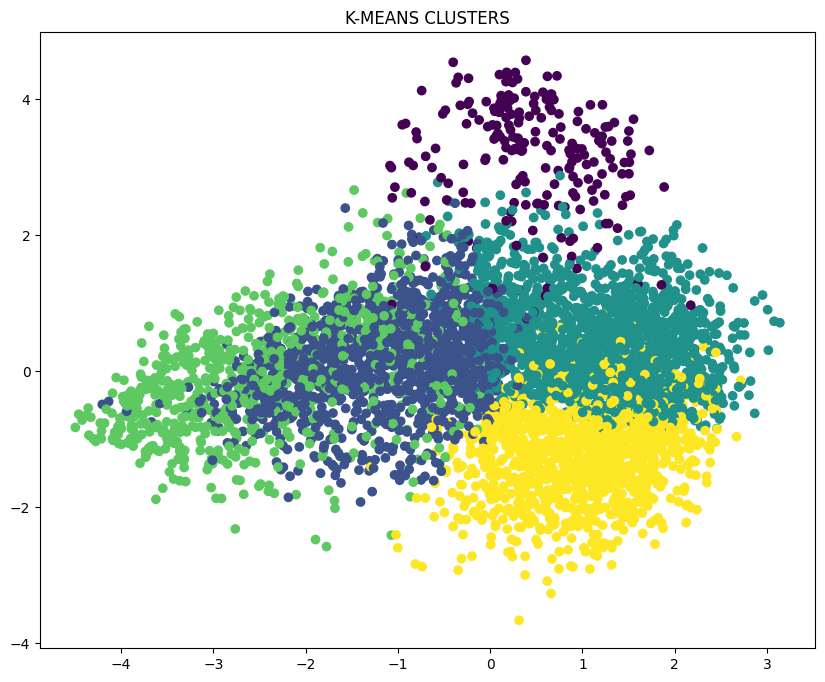

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
plt.figure(figsize=(10,8))
plt.scatter(pca_result[:,0], pca_result[:,1], c=df['Cluster'],cmap='viridis')
plt.title("K-MEANS CLUSTERS")
plt.show()

# RECOMMENDATION SYSTEM WITH KMEANS

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def recommend_songs(song_name, df, num_recommendations=5):
  # get cluster for the input song
  song_cluster = df[df['name']==song_name]['Cluster'].values[0]
  # filter all single present in this cluster
  same_cluster_songs = df[df['Cluster']==song_cluster]
  # calulate similarity within the same cluster
  song_index = same_cluster_songs[same_cluster_songs['name']==song_name].index[0]
  cluster_features = same_cluster_songs[numerical_features]
  similarity = cosine_similarity(cluster_features, cluster_features)
  # get top recommendations
  similar_songs = np.argsort(similarity[song_index])[-(num_recommendations + 1):-1][::-1]
  recommendations = same_cluster_songs.iloc[similar_songs][['name','year','artists']]
  return recommendations

In [ ]:
# example usage
input_song = "Camby Bolongo"
recommended_songs = recommend_songs(input_song, df, num_recommendations=5)

print(f"Songs similar to '{input_song}':")
recommended_songs

Songs similar to 'Camby Bolongo':


,name,year,artists
3444,Bitch to the Boys,1982,['Shakatak']
3027,Chella llà - Instrument and base Version,1942,['Orchestra Studio 7']
4899,Danse Fambeaux,1968,['Dr. John']
3124,"Aragon - From The ""Coffy"" Soundtrack",1973,['Roy Ayers']
647,Into Black,2011,['Blouse']


In [ ]:
# example usage
input_song = "Soul Junction"
recommended_songs = recommend_songs(input_song, df, num_recommendations=5)

print(f"Songs similar to '{input_song}':")
recommended_songs

Songs similar to 'Soul Junction':


,name,year,artists
868,"Piano Sonata No. 2, Op. 35, in B-Flat Minor: F...",1946,"['Frédéric Chopin', 'Arthur Rubinstein']"
2766,"Cello Concerto in B-Flat Major, G. 483: I. All...",1951,"['Luigi Boccherini', 'János Starker', 'Maximil..."
4180,"Piano Concerto in A Minor, Op. 54: II. Interme...",1945,"['Robert Schumann', 'Claudio Arrau', 'Karl Kru..."
2989,En aften med dig,1943,['Raquel Rastenni']
2673,Whale & Wasp,1994,['Alice In Chains']


In [ ]:
df.to_csv("cluster_df.csv")